In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from src.utils import load_json

In [67]:
# Load experiments.csv

res_dir = "/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn"
exp = pd.read_csv(f"{res_dir}/experiments.csv", sep='\t', index_col=0)
exp.tail(10)

,n_epochs,pred_head,message_passing,agg,d_h_encoder,model,featurizer,encoder_depth,toc,n_splits,split_strategy,neg_multiple,embed_type,seed,dataset_name,split_sim_threshold,embed_dim
254,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.8,1280
255,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.8,1280
256,25,dot_sig,bondwise,last,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
257,25,dot_sig,bondwise,last,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
258,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
259,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
260,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,4.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280
261,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280
262,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,4.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280
263,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_simple,5.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.4,1280


In [68]:
exp.drop(labels=[i for i in range(260, 264)], inplace=True)
exp.tail()

,n_epochs,pred_head,message_passing,agg,d_h_encoder,model,featurizer,encoder_depth,toc,n_splits,split_strategy,neg_multiple,embed_type,seed,dataset_name,split_sim_threshold,embed_dim
255,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,rcmcs,1,esm,1234,sprhea,0.8,1280
256,25,dot_sig,bondwise,last,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
257,25,dot_sig,bondwise,last,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
258,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,5.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280
259,25,dot_sig,bondwise,mean,300,mpnn_dim_red,rxn_rc,6.0,v3_folded_pt_ns,5,homology,1,esm,1234,sprhea,0.8,1280


In [69]:
# Bring in test scores

for hi, row in exp.iterrows():
    agg_scores = defaultdict(list)
    n_splits = row['n_splits']
    for si in range(n_splits):
        scores = load_json(f"{res_dir}/{hi}_hp_idx_split_{si+1}_of_{n_splits}/version_0/test_scores.json")
        for name, val in scores.items():
            agg_scores[name].append(val)

    if hi == 0:
        for name in agg_scores.keys():
            exp[f"{name}_mean"] = np.NaN
            exp[f"{name}_sem"] = np.NaN
    
    for name, val in agg_scores.items():
        exp.loc[hi, f"{name}_mean"] = np.array(val).mean()
        exp.loc[hi, f"{name}_sem"] = np.array(val).std() / np.sqrt(n_splits)

exp.head()

,n_epochs,pred_head,message_passing,agg,d_h_encoder,model,featurizer,encoder_depth,toc,n_splits,...,split_sim_threshold,embed_dim,f1_mean,f1_sem,precision_mean,precision_sem,recall_mean,recall_sem,accuracy_mean,accuracy_sem
0,25,dot_sig,NaN,NaN,20,ffn,mfp,3.0,sp_folded_pt,5,...,0.8,1280,0.620535,0.029416,0.916369,0.013761,0.472561,0.031651,0.715904,0.016321
1,25,dot_sig,NaN,NaN,20,ffn,mfp,2.0,sp_folded_pt,5,...,0.8,1280,0.617538,0.031305,0.915270,0.014218,0.469564,0.034096,0.714689,0.017508
2,25,dot_sig,NaN,NaN,20,ffn,mfp,1.0,sp_folded_pt,5,...,0.8,1280,0.701963,0.025896,0.930098,0.012949,0.565944,0.030328,0.763964,0.013884
3,25,dot_sig,NaN,NaN,50,ffn,mfp,3.0,sp_folded_pt,5,...,0.8,1280,0.611627,0.031135,0.924502,0.015380,0.459779,0.032920,0.713284,0.017152
4,25,dot_sig,NaN,NaN,50,ffn,mfp,2.0,sp_folded_pt,5,...,0.8,1280,0.690189,0.029732,0.933042,0.011475,0.551174,0.034836,0.757626,0.016938


In [70]:
# Filter, sort, order cols for display

filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
cols_to_display = [
    # 'toc',
    'model',
    'agg',
    'pred_head',
    'featurizer',
    'd_h_encoder',
    'encoder_depth',
    'n_epochs',
    'f1_mean',
    'precision_mean',
    'recall_mean',
    'accuracy_mean',
    'f1_sem',
    'precision_sem',
    'recall_sem',
    'accuracy_sem'
]
sortby = ['f1_mean']

display_res = exp.loc[filter_by_toc & filter_by_task, cols_to_display]
display_res.sort_values(by=sortby, ascending=False).head(20)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
254,mpnn_dim_red,mean,dot_sig,rxn_rc,300,5.0,25,0.799504,0.936557,0.702163,0.834256,0.028349,0.005496,0.039903,0.022786
194,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,25,0.799021,0.936098,0.702089,0.833610,0.028349,0.005670,0.040614,0.022923
195,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,25,0.798088,0.938365,0.699055,0.833358,0.027964,0.003974,0.040428,0.022841
210,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,35,0.790688,0.936461,0.689736,0.828566,0.029650,0.005280,0.042225,0.023411
211,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,35,0.790059,0.938166,0.689262,0.828157,0.032914,0.004349,0.047020,0.025869
255,mpnn_dim_red,mean,dot_sig,rxn_rc,300,6.0,25,0.789494,0.935995,0.689823,0.827776,0.033967,0.005514,0.048651,0.026651
191,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,25,0.789243,0.922881,0.693495,0.825358,0.025572,0.005694,0.036957,0.021017
190,mpnn_dim_red,mean,dot_sig,rxn_rc,50,3.0,25,0.788764,0.922598,0.692394,0.824504,0.022841,0.006547,0.033432,0.019387
207,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,35,0.784093,0.923733,0.686532,0.821932,0.028070,0.006108,0.041025,0.022700
193,mpnn_dim_red,mean,dot_sig,rxn_rc,300,2.0,25,0.783849,0.932285,0.678820,0.822575,0.020993,0.006120,0.029543,0.018044


In [71]:
# Display all w/in MOE of best

best = 254
metric = 'f1'
metric_mean, metric_sem = f"{metric}_mean", f"{metric}_sem"
filter_by_performance = (display_res.loc[best, metric_mean] - display_res[metric_mean] < display_res.loc[best, metric_sem])
display_res.loc[filter_by_performance].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
254,mpnn_dim_red,mean,dot_sig,rxn_rc,300,5.0,25,0.799504,0.936557,0.702163,0.834256,0.028349,0.005496,0.039903,0.022786
194,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,25,0.799021,0.936098,0.702089,0.833610,0.028349,0.005670,0.040614,0.022923
195,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,25,0.798088,0.938365,0.699055,0.833358,0.027964,0.003974,0.040428,0.022841
210,mpnn_dim_red,mean,dot_sig,rxn_rc,300,3.0,35,0.790688,0.936461,0.689736,0.828566,0.029650,0.005280,0.042225,0.023411
211,mpnn_dim_red,mean,dot_sig,rxn_rc,300,4.0,35,0.790059,0.938166,0.689262,0.828157,0.032914,0.004349,0.047020,0.025869
255,mpnn_dim_red,mean,dot_sig,rxn_rc,300,6.0,25,0.789494,0.935995,0.689823,0.827776,0.033967,0.005514,0.048651,0.026651
191,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,25,0.789243,0.922881,0.693495,0.825358,0.025572,0.005694,0.036957,0.021017
190,mpnn_dim_red,mean,dot_sig,rxn_rc,50,3.0,25,0.788764,0.922598,0.692394,0.824504,0.022841,0.006547,0.033432,0.019387
207,mpnn_dim_red,mean,dot_sig,rxn_rc,50,4.0,35,0.784093,0.923733,0.686532,0.821932,0.028070,0.006108,0.041025,0.022700
193,mpnn_dim_red,mean,dot_sig,rxn_rc,300,2.0,25,0.783849,0.932285,0.678820,0.822575,0.020993,0.006120,0.029543,0.018044


In [6]:
# VN agg, how large of a radius?

filter_vn_agg = (display_res['agg'] == 'last') & (display_res['featurizer'] == 'rxn_rc') & (display_res['pred_head'] != 'binary')
display_res.loc[filter_vn_agg & filter_by_performance].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
203,mpnn_dim_red,last,dot_sig,rxn_rc,300,4.0,25,0.783828,0.930978,0.680691,0.822922,0.025397,0.006231,0.036216,0.020562
252,mpnn_dim_red,last,dot_sig,rxn_rc,300,5.0,25,0.775896,0.926463,0.670524,0.816347,0.024221,0.006100,0.033515,0.020764


In [7]:
# Non-GNN benchmarks
filter_non_gnn = (display_res['model'] == 'ffn') | (display_res['model'] == 'linear')
display_res.loc[filter_non_gnn].sort_values(by=[metric_mean], ascending=False)

,model,agg,pred_head,featurizer,d_h_encoder,encoder_depth,n_epochs,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_sem,precision_sem,recall_sem,accuracy_sem
185,linear,NaN,dot_sig,mfp,300,NaN,25,0.717689,0.943746,0.584895,0.784827,0.033938,0.004400,0.043090,0.024183
187,linear,NaN,dot_sig,mfp,300,NaN,35,0.713790,0.941233,0.583255,0.782087,0.038958,0.006469,0.049749,0.027349
186,linear,NaN,dot_sig,mfp,50,NaN,35,0.710052,0.926764,0.582240,0.777073,0.034257,0.007515,0.044066,0.024932
184,linear,NaN,dot_sig,mfp,50,NaN,25,0.696475,0.923728,0.564173,0.768702,0.031604,0.008089,0.039301,0.023386


# TODO: Loss curves

In [128]:
gs_name = "mfp_ffn_homology_80_0"
gs_path = f"/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/{ds_toc}_{gs_name}"
hp_idx = 5
n_splits = 5

loss_curves = defaultdict(lambda: defaultdict()) # 'hpidx_sidx': {epochs: [int], losses: [float])
for sidx in range(n_splits):
    hsd = f"{hp_idx}_hp_idx_split_{sidx + 1}_of_{n_splits}"
    lc = pd.read_csv(f"{gs_path}/{hsd}/version_0/metrics.csv", sep=',')
    ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index() # Average over epochs
    loss_curves[hsd]['epochs'] = ep_ave_lc.loc[:, 'epoch'].to_numpy()
    loss_curves[hsd]['losses'] = ep_ave_lc.loc[:, 'train_loss'].to_numpy()

# tr_losses = np.vstack(tr_losses)
# loss_curves["losses"] = tr_losses.mean(axis=1)
# loss_curves[""]



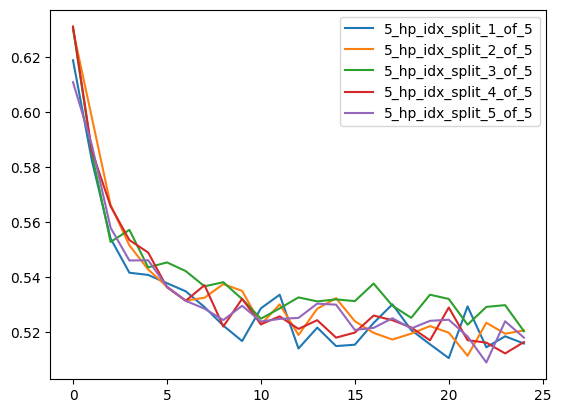

In [129]:
fig, ax = plt.subplots()
for k,v in loss_curves.items():
    ax.plot(v['epochs'], v['losses'], label=k)

ax.legend()
plt.show()

In [125]:
bad_lc = {k:v for k,v in loss_curves.items() if v['losses'][-1] > 0.4}
sorted(bad_lc.keys())

[]

# Performance figures

In [122]:
def clustered_multi_panel_bar_chart(
        extract:pd.DataFrame,
        cluster_sels,
        x_sels,
        metrics,
        cluster_labels,
        x_labels,
        colors,
        xaxis_label=None,
    ):
    if x_sels:
        x = np.arange(-len(cluster_sels) / 2, )
    x = np.arange(max(1, len(x_sels))) # x locations
    width = 0.3  # the width of the bars

    _, ax = plt.subplots(ncols=len(metrics), sharey=True, figsize=(11,3), constrained_layout=True)

    for i, m in enumerate(metrics):
        for j, cs in enumerate(cluster_sels):
            means = []
            errors = []
            if x_sels:
                for k, xs in enumerate(x_sels):
                    means.append(extract.loc[cs & xs, f"{m}_mean"].to_numpy()[0])
                    errors.append(extract.loc[cs & xs, f"{m}_sem"].to_numpy()[0])
            else:
                means.append(extract.loc[cs, f"{m}_mean"].to_numpy()[0])
                errors.append(extract.loc[cs, f"{m}_sem"].to_numpy()[0])
                
            offset = width * (j - (len(cluster_sels) / 2) + 0.5)
            rects = ax[i].bar(x + offset, means, yerr=errors, width=width, label=cluster_labels[j], color=colors[j])
            ax[i].set_xticks(x)
            ax[i].set_xticklabels(x_labels)
            ax[i].set_title(f"{m.capitalize()}")

    ax[-1].legend(loc='lower right', fontsize=11)
    ax[0].set_ylim(0,1)
    ax[0].set_yticks(np.arange(0, 1.1, 0.1))
    if xaxis_label:
        ax[0].set_xlabel(xaxis_label)
    plt.show()


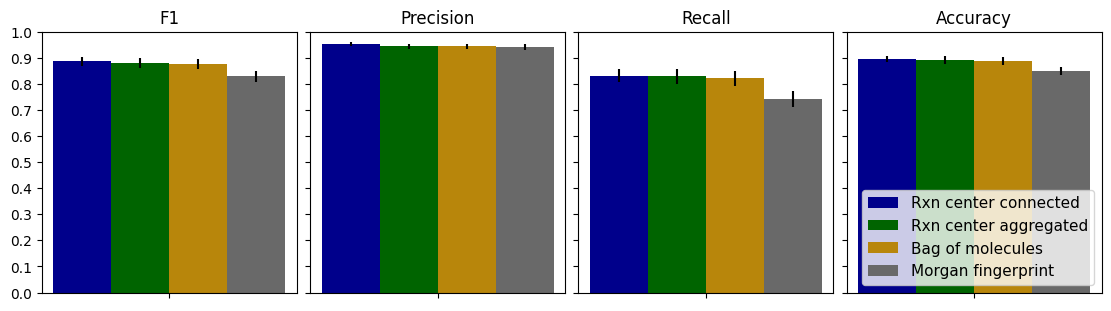

In [129]:
# Compare best & benchmarks on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
mfp = (exp['featurizer'] == 'mfp')

tmp = []
for sel in [bag_of_mols, rc_aug, rc_agg, mfp]:
    slice = exp.loc[sel & common]
    arg_best = slice[srt_metric_mean].idxmax()
    tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head()


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
    mfp
]

x_sels = [
    
]

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
    "Morgan fingerprint"
]

x_labels = [

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    "dimgray",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

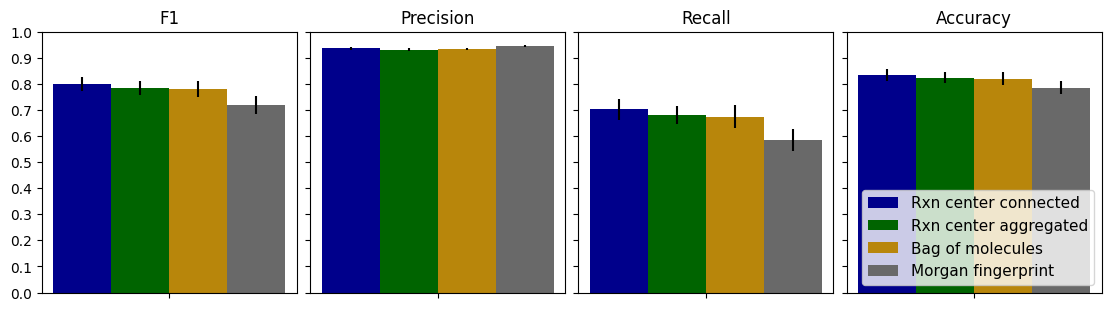

In [130]:
# Compare best & benchmarks on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = (exp['featurizer'] == 'rxn_simple')
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
mfp = (exp['featurizer'] == 'mfp')

tmp = []
for sel in [bag_of_mols, rc_aug, rc_agg, mfp]:
    slice = exp.loc[sel & common]
    arg_best = slice[srt_metric_mean].idxmax()
    tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head()


metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
    mfp
]

x_sels = [
    
]

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
    "Morgan fingerprint"
]

x_labels = [

]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    "dimgray",
    
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

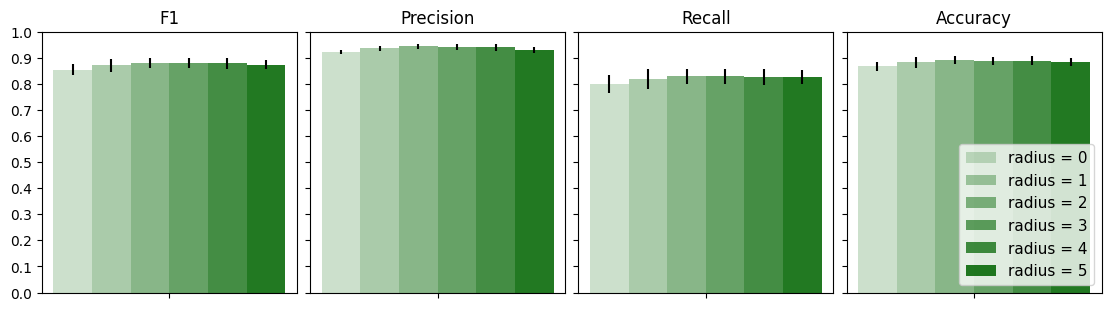

In [125]:
# Compare RC radius on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

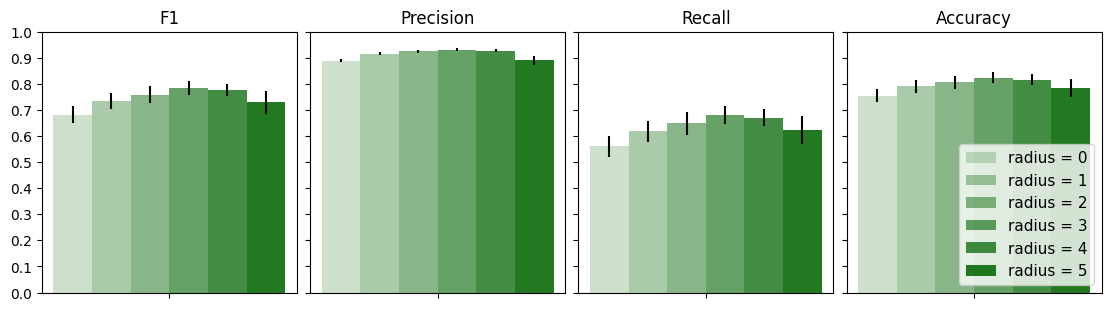

In [126]:
# Compare RC radius on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = exp['toc'] == 'v3_folded_pt_ns'
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
filter_by_dh = exp['d_h_encoder'] == 300
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')
common = filter_by_pred_head & filter_by_task & filter_by_toc & rc_agg & filter_by_dh

extract = exp.loc[common].sort_values(by=[srt_metric_mean], ascending=False)

darkgreen_rgb = list(matplotlib.colors.to_rgba('darkgreen')[:-1])

metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [exp['encoder_depth'] == n for n in range(1, 7)]

x_sels = [
    
]

cluster_labels = [f"radius = {n-1}" for n in range(1, 7)]

x_labels = [

]

colors = [darkgreen_rgb + [alpha] for alpha in np.linspace(0.2, 1.0, num=7)  
]

clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors
)

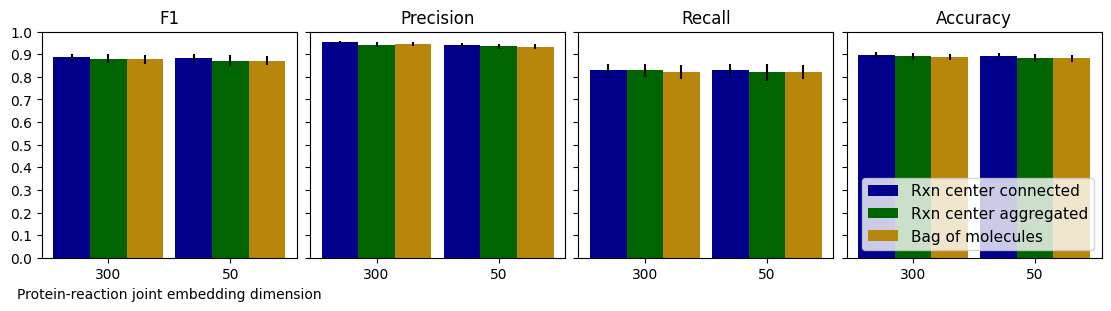

In [131]:
# Compare best models w/ diff hidden dimensions on 80% homology

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'homology') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')



metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['d_h_encoder'] == 300,
    exp['d_h_encoder'] == 50,
    
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head(20)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "300",
    "50",
]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="Protein-reaction joint embedding dimension",
)

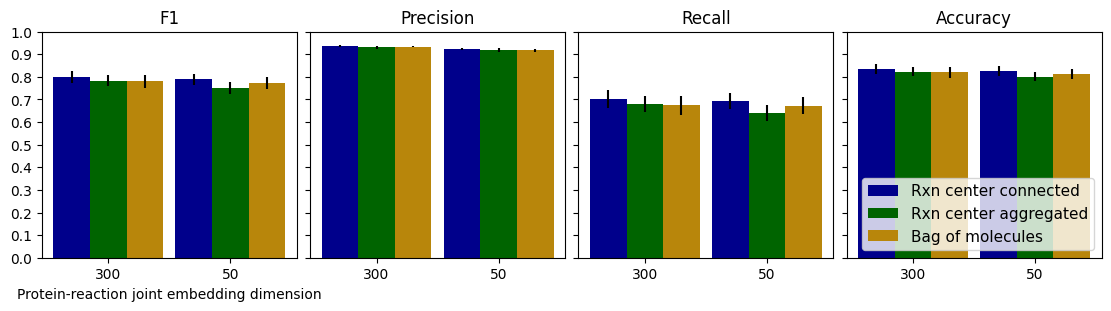

In [132]:
# Compare best models w/ diff hidden dimensions on 80% rcmcs

srt_metric_mean = "f1_mean"
filter_by_toc = (exp['toc'] == 'v3_folded_pt_ns')
filter_by_task = (exp['split_strategy'] == 'rcmcs') & (exp['split_sim_threshold'] == 0.8)
filter_by_pred_head = exp['pred_head'] == "dot_sig"
common = filter_by_pred_head & filter_by_task & filter_by_toc
bag_of_mols = exp['featurizer'] == 'rxn_simple'
rc_aug = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'mean')
rc_agg = (exp['featurizer'] == 'rxn_rc') & (exp['agg'] == 'last')



metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_sels = [
    rc_aug,
    rc_agg,
    bag_of_mols,
]

x_sels = [
    exp['d_h_encoder'] == 300,
    exp['d_h_encoder'] == 50,
    
]

tmp = []
for cs in cluster_sels:
    for xs in x_sels:
        slice = exp.loc[cs & xs & common]
        arg_best = slice[srt_metric_mean].idxmax()
        tmp.append(slice.loc[[arg_best], :])

extract = pd.concat(tmp)
extract.head(20)

cluster_labels = [
    "Rxn center connected",
    "Rxn center aggregated",
    "Bag of molecules",
]

x_labels = [
    "300",
    "50",
]

colors = [
    "darkblue",
    "darkgreen",
    "darkgoldenrod",
    
]
clustered_multi_panel_bar_chart(
    extract,
    cluster_sels,
    x_sels,
    metrics,
    cluster_labels,
    x_labels,
    colors,
    xaxis_label="Protein-reaction joint embedding dimension",
)